---
# 1 Introducción
El siguiente cuaderno realiza la funcion Exponencial de todo un vectores  utilizando GPGPU.

 Las funciones exponenciales tienen la forma image.png, donde b > 0 y b ≠ 1. Al igual que cualquier expresión exponencial, b se llama base y x se llama exponente.

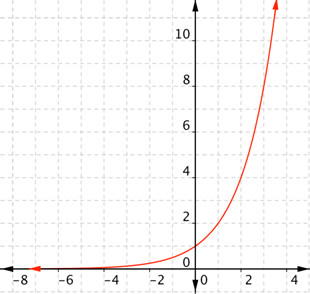


---
#2 Armado de Ambientes
Instala en el cuaderno el módulo CUDA de Python.


In [2]:
!pip install pycuda


---
#3 Desarrollo

In [1]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }
cantidad_N =   50#@param {type: "number"}
exponente =   10#@param {type: "number"}
# --------------------------------------------

from datetime import datetime

tiempo_total = datetime.now()

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# --------------------------------------------
# CPU - Defino la memoria de los vectores en cpu.
x_cpu = numpy.random.randn( cantidad_N ) *10
x_cpu = x_cpu.astype( numpy.float32() )
r_cpu = numpy.random.randn( cantidad_N)
r_cpu = r_cpu.astype( numpy.float32())
# El resultado se escribe sobre el vector R.
# --------------------------------------------

#tiempo_ini_cpu = datetime.now()

#r_cpu = numpy.empty_like( x_cpu )

# CPU - reservo la memoria GPU.
x_gpu = cuda.mem_alloc( x_cpu.nbytes )
r_gpu = cuda.mem_alloc( r_cpu.nbytes )
# --------------------------------------------
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( x_gpu, x_cpu )
cuda.memcpy_htod( r_gpu, r_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_exponencial( float n, float exponente, float *X, float *Y )
{
  #include <math.h>
  __syncthreads();
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  if( idx < n )
  {
    Y[idx]  = pow( X[idx] ,exponente);
  }
}
""") 
# CPU - Genero la función kernel.
kernel = module.get_function("kernel_exponencial")

tiempo_gpu = datetime.now()

# GPU - Ejecuta el kernel.
# TODO: Falta consultar limites del GPU, para armar las dimensiones correctamente.
dim_hilo = 256
dim_bloque = numpy.int( (cantidad_N+dim_hilo-1) / dim_hilo )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

#TODO: Ojo, con los tipos de las variables en el kernel.
kernel( numpy.float32(cantidad_N),numpy.float32(exponente), x_gpu, r_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( r_gpu,r_cpu )


# CPU - Informo el resutlado.
print( "------------------------------------")
print( "Vector de entrada: " )
print( x_cpu )
print( "------------------------------------")
print( "Resultado: " )
print( r_cpu )
print( "------------------------------------")

tiempo_total = datetime.now() - tiempo_total

print( "Cantidad de elementos: ", cantidad_N )
print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
print("Tiempo CPU: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )


Thread x:  256 , Bloque x: 1


ArgumentError: ignored

---
#4 Tabla de pasos
 Procesador | Función | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  numpy.random.randn( Cantidad_N ) | Inicializa los vectoes X y R
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU memoria A a CPU memoria R.
CPU      |  print()               | Informo los resultados.

---
# 5 Conclusiones 
Luego de haber tenido la problematica de como implementar la funcion Pow en Cuda, invesigando se llegó a la conclusion que era necesaria la funcion **pow(b,x)** propia de la libreria <math.h > que como resultado devuelve un float , trayendo consecuencias por que manejaba enteros, debiendo modificar el tipo de dato de los vectores trabajados de enteros en una primera instancia a floats.

Dada esa primera aclaración se puede apreciar que el costo en cuanto a tiempo de procesamiento siendo delegado al GPU. es infimamente inferior que el que procesaria si solo fuera el CPU. Es muy recomendable el uso de GPU  para reducir la complejidad computacional. Si bien el ejemplo es muy simple, es aún más fácil comprender lo rico e interesante que es trabajar con este tipo de plataformas, a su vez. queda abierto a futuro la posibilidad de invesigar o descubrir si de alguna forma podemos se llegase a mandar el trabajo de imprimir o mostrar en pantalla del lado del GPU

---
#6 Bibliografía

[1] Función Axpy explicada en clases [Referencia](https://colab.research.google.com/drive/1pvG-U2pZGLn7wi1sZrpZaSIimclDxhz6#scrollTo=_ZSyvriolXg1)

[2] Introducción a las funciones Exponenciales [Referencia](https://www.montereyinstitute.org/courses/DevelopmentalMath/TEXTGROUP-15-19_RESOURCE/U18_L1_T1_text_final_es.html#:~:text=Las%20funciones%20exponenciales%20tienen%20la,y%20x%20se%20llama%20exponente.&text=Con%20la%20definici%C3%B3n%20f(x,de%20todos%20los%20n%C3%BAmeros%20reales.)

[3] Clases explicadas en Teams

[4] Como manejar la funcion pow en CUDA [Referencia](https://stackoverflow.com/questions/5656605/pycuda-pow-within-device-code-tries-to-use-stdpow-fails)

[5] CUDA (Arquitectura Unificada de Dispositivos de Cómputo)  [Referencia](https://es.wikipedia.org/wiki/CUDA) 